# Function Approximation

In [1]:
import gym
import numpy
import itertools
from matplotlib import pyplot
import seaborn
from mpl_toolkits.mplot3d import Axes3D
import tiles3

In [2]:
seaborn.set_style('ticks')

## Mountain Car Environment

In [3]:
env = gym.make('MountainCar-v0')
env.action_space, env.observation_space

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


(Discrete(3), Box(2,))

In [4]:
env.observation_space.low, env.observation_space.high

(array([-1.2 , -0.07], dtype=float32), array([0.6 , 0.07], dtype=float32))

In [5]:
env.reset()
for t in range(100):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
env.close()

## Semi-gradient Sarsa

In [6]:
# refer to http://incompleteideas.net/tiles/tiles3.html
max_size = 2048
# index hash table
iht = tiles3.IHT(max_size)

n_tilings = 8
alpha = 0.1 / n_tilings

def x(S, A):
    position, velocity = S
    scale_position = 10 / (env.observation_space.high[0] - env.observation_space.low[0])
    scale_velocity = 10 / (env.observation_space.high[1] - env.observation_space.low[1])
    xs = numpy.zeros(max_size, numpy.int)
    floats = [position * scale_position, velocity * scale_velocity]
    xs[tiles3.tiles(iht, n_tilings, floats, ints=[A])] = 1
    return xs

def epsilon_greedy_policy(env, S, w, epsilon):
    if numpy.random.rand() < epsilon:
        return env.action_space.sample()
    return numpy.argmax([x(S, A) @ w.T for A in range(env.action_space.n)])

def semi_gradient_sarsa(env, n_episodes, alpha=0.01, gamma=1.0, epsilon=0.1):
    w = numpy.zeros(max_size)
    for i in range(n_episodes):
        S = env.reset()
        A = epsilon_greedy_policy(env, S, w, epsilon)
        for t in itertools.count():
            S_prime, R, done, _ = env.step(A)
            if done:
                w += alpha * (R - x(S, A) @ w.T) * x(S, A)
                break
            A_prime = epsilon_greedy_policy(env, S, w, epsilon)
            w += alpha * (R + gamma * (x(S_prime, A_prime) @ w.T) - x(S, A) @ w.T) * x(S, A)
            S, A = S_prime, A_prime
    return w

w = semi_gradient_sarsa(env, 1000, alpha=alpha)
w

IHT full, starting to allow collisions


array([-11.2755797 , -11.65891194, -11.17106619, ...,  -0.15896457,
        -0.02328538,   0.        ])

Text(0.5,0,'velocity')

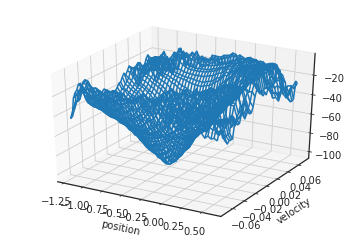

In [7]:
positions = numpy.linspace(env.observation_space.low[0], env.observation_space.high[0])
speeds = numpy.linspace(env.observation_space.low[1], env.observation_space.high[1])

V = numpy.zeros((50, 50))
for i, position in enumerate(positions):
    for j, speed in enumerate(speeds):
        V[i, j] = numpy.max([x([position, speed], A) @ w.T for A in range(env.action_space.n)])

X, Y = numpy.meshgrid(positions, speeds)
fig, ax = pyplot.subplots(subplot_kw={'projection': '3d'})
ax.plot_wireframe(X, Y, V.T)
ax.set_xlabel('position')
ax.set_ylabel('velocity')

In [8]:
env = gym.make('MountainCar-v0')
S = env.reset()
for t in itertools.count():
    env.render()
    action = numpy.argmax([x(S, A) @ w.T for A in range(env.action_space.n)])
    S, R, done, _ = env.step(action)
    if done:
        break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
